In [1]:
import numpy as np
from scipy.integrate import odeint

import torch
from torch.autograd import Function
import torch.nn as nn
import pyro
from pyro.nn import PyroSample
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import AdagradRMSProp

from util.plot_pairwise import pairwise
import matplotlib.pyplot as plt
%matplotlib inline

# Goodwin oscillator with three species

The Goodwin oscillator model describes the basic mechanism for periodic protein expression that is driven by a negative feedback loop which inhibits mRNA transcription. \cite{calderhead2009estimating} used this model to evaluate a method for obtaining the marginal likelihood. The three species version of this model is given by 

\begin{aligned}
\frac{d x_1}{dt}&=\frac{a_1}{1+ a_2 x^p_3} - \alpha x_1 \\
\frac{d x_2}{dt}&=k_1 x_1 - \alpha x_2\\
\frac{d x_3}{dt}&= k_2 x_2 - \alpha x_3,
\end{aligned}

where $x_1(t)$ denotes mRNA and $x_2(t)$, $x_3(t)$ the protein concentrations. The output of this coupled ODE depends upon synthesis rate constants $a_1,k_1,k_2$ and degradation constants $\alpha,a_2$. The Goodwin model produces oscillatory solutions only when $p>8$ and thus we set $p=10$.

 Let me first write down the code to solve this ODE using the `scipy`'s `odeint`. The `jac_x` and `jac_p` are the state and parameter Jacobians

In [2]:
class GoodwinModel(object):

    def __init__(self, times, y0=None):

        if y0 is None:
            self._y0 = np.array([0,0,0], dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)
        self._n_states = 3
        self._n_params = 5
        self._times = times
        self._T = len(times)
            
    def solve(self, parameters):
        return self._solve(parameters, False)

    def solve_with_sensitivities(self, parameters):
        return self._solve(parameters, True)

    def _solve(self, parameters, sensitivities):
        a1, a2, alpha, k1, k2 = [float(x) for x in parameters]       

        def r(y, t, p):
            
            X1, X2, X3=y
            dX1_dt = (a1/( 1 + (a2*(X3**10)) ) ) - (alpha*X1);
            dX2_dt = (k1*X1) - (alpha*X2);
            dX3_dt = (k2*X2) - (alpha*X3);
            
            return dX1_dt,dX2_dt,dX3_dt

        if sensitivities:
            def jac_x(y):
                X1, X2, X3 = y
                ret = np.empty((self._n_states, self._n_states))
                ret[0, 0] = -alpha
                ret[0, 1] = 0
                ret[0, 2] = -(a1*a2*10*(X3**9))/( (1 + a2*(X3**10))**2 )
                
                ret[1, 0] = k1
                ret[1, 1] = -alpha
                ret[1, 2] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = k2
                ret[2, 2] = -alpha
                return ret

            def jac_p(y):
                X1, X2, X3 = y
                ret = np.empty((self._n_states, self._n_params))
                ret[0, 0] = 1/(1+a2*(X3**10))
                ret[0, 1] = -(a1*(X3**10))/( (1 + a2*(X3**10))**2 )
                ret[0, 2] = -X1
                ret[0, 3] = 0
                ret[0, 4] = 0
                
                ret[1, 0] = 0
                ret[1, 1] = 0
                ret[1, 2] = -X2
                ret[1, 3] = X1
                ret[1, 4] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = 0
                ret[2, 2] = -X3
                ret[2, 3] = 0
                ret[2, 4] = X2               
                return ret

            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0:self._n_states]
                dydp = y_and_dydp[self._n_states:].reshape((self._n_states, self._n_params))

                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac_x(y), dydp) + jac_p(y)

                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))

            y0 = np.zeros(18)
            y0[0:self._n_states] = self._y0
            result = odeint(rhs, y0, self._times, (parameters,), rtol=1e-5, atol=1e-6)
            x = result[:, 0:self._n_states]
            dx_dp = result[:, self._n_states:].reshape((self._T, self._n_states, self._n_params))
            return x, dx_dp, self._T, self._n_states, self._n_params
        else:
            x = odeint(r, self._y0, self._times, (parameters,), rtol=1e-5, atol=1e-6)
            return x


## Simulated (fake) data

We generated data from the above model with parameters $a_1=1.97$, $a_2=0.15$, $\alpha=0.53$, $k_1=0.4$ and $k_2=1.49$ and initial conditions $(x_1(t_0),x_2(t_0),x_3(t_0))$ set to zero. We added noise to all the states with $\sigma_x=0.1$

Text(0, 0.5, 'Concentration')

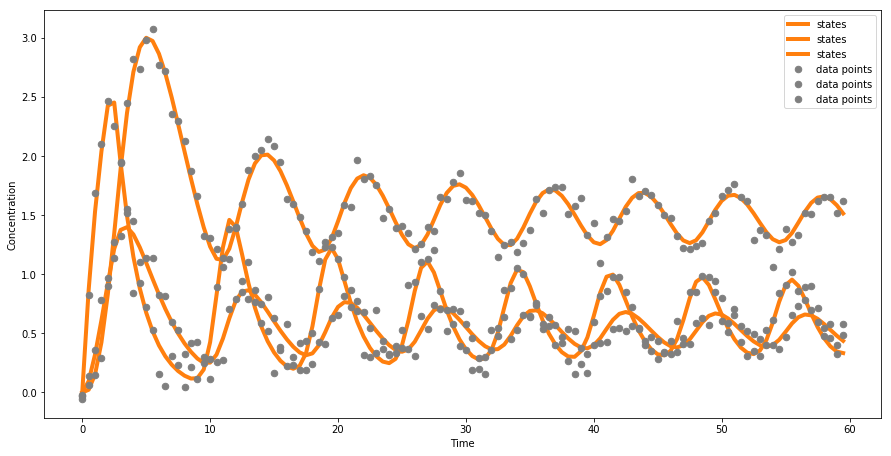

In [3]:
times = np.arange(0,60, 0.5)
gw_ode_model = GoodwinModel(times);
sigma=0.1
real_params = [1.97,0.15,0.53,0.46,1.49]
sol=gw_ode_model.solve(real_params)
np.random.seed(121) 
Y=sol+np.random.randn(120,3)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='states')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')

## Custom ODE op

Writing a custom op in `PyTorch` is perhaps the simplest when compared to other standard AD software. Note how we are using the `ctx` to make sure we don't call the ODE solver twice.

In [4]:
class ODEop(Function):  
    @staticmethod
    def forward(ctx, params): 
        numpy_params = params.detach().numpy()
        
        states, Jac_p, T, k, d = gw_ode_model.solve_with_sensitivities(numpy_params)
        ctx.T, ctx.k, ctx.d = T, k, d
        ctx.save_for_backward(torch.as_tensor(Jac_p, dtype=params.dtype))
        return torch.as_tensor(states, dtype=params.dtype)

    @staticmethod
    def backward(ctx, grad_output):
        T = ctx.T
        d = ctx.d
        k = ctx.k
        bJac = ctx.saved_tensors[0]
        numpy_Jac = bJac.detach().numpy().reshape((k*T,d))
        g = grad_output.detach().numpy().reshape(k*T)
        vjp = g.T.dot(numpy_Jac)          
        return torch.from_numpy(vjp)

In [5]:
y_torch = torch.tensor(Y,dtype=torch.float)

## The probabilistic (generative) model

We consider the initial values to be known. That leaves six unknown parameters $\boldsymbol{\theta}=(a_1,a_2,\alpha,k_1,k_2, \sigma_x)$ to be estimated. For inference we placed a $\operatorname{Gamma}(2,1)$ prior on all the five ODE parameters and a half-Normal, $\mathcal{H}(1)$, prior on the noise standard deviation parameter. The likelihood is given by $p(\boldsymbol{y}|\boldsymbol{x}(\boldsymbol{\theta}))=\underset{t}{\prod}\mathcal{N}(\boldsymbol{x}(t),\sigma_x^2\mathbb{I})$.

In [6]:
class GoodwinGenModel(PyroModule):
    def __init__(self):        
        super(GoodwinGenModel, self).__init__()
        self.ode_params = PyroSample(dist.Gamma(
            torch.tensor([2.0,2.0,2.0,2.0,2.0]),1.0).to_event(1) )      
        
    def forward(self, data):         
        scale = pyro.sample("scale", dist.HalfNormal(1.0))
        states = ODEop.apply(self.ode_params)
        with pyro.plate("map", len(data)):

            pyro.sample("obs",
                        dist.Normal(states, scale).to_event(1),
                        obs=data)
            return states

## The variational posterior (the guide)

We set the vaariational approximation as the full-rank multi-variate Normal. `AutoMultivariateNormal` approximation provided by `Pyro` handles all the necessary support transformation, according to the prior's support constraints.

In [7]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
model = GoodwinGenModel()
guide = AutoMultivariateNormal(model)
optim = AdagradRMSProp({"eta": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

### Build a training loop and maximise the ELBO

In [8]:
def train():
    loss_trace = []
    for j in range(30000):
        # calculate the loss and take a gradient step
        loss = svi.step(y_torch)
        loss_trace.append(loss)

        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
    return loss_trace

In [9]:
%%time
loss_graph = train()
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

[iteration 0001] loss: 514.3626
[iteration 0501] loss: 67.3555
[iteration 1001] loss: -116.1302
[iteration 1501] loss: -211.6285
[iteration 2001] loss: -257.6240
[iteration 2501] loss: -273.2547
[iteration 3001] loss: -285.0957
[iteration 3501] loss: -282.5965
[iteration 4001] loss: -290.3048
[iteration 4501] loss: -290.3658
[iteration 5001] loss: -293.5598
[iteration 5501] loss: -292.5541
[iteration 6001] loss: -294.5683
[iteration 6501] loss: -294.2982
[iteration 7001] loss: -294.1445
[iteration 7501] loss: -296.0449
[iteration 8001] loss: -295.6449
[iteration 8501] loss: -297.9463
[iteration 9001] loss: -296.6749
[iteration 9501] loss: -296.0185
[iteration 10001] loss: -297.2748
[iteration 10501] loss: -297.5599
[iteration 11001] loss: -297.5529
[iteration 11501] loss: -298.1664
[iteration 12001] loss: -297.9659
[iteration 12501] loss: -297.1826
[iteration 13001] loss: -298.3098
[iteration 13501] loss: -298.6330
[iteration 14001] loss: -298.3626
[iteration 14501] loss: -298.4814
[it

## Posterior predictives

`Pyro` provides the `Predictive` class to draw the necessay posterior predictives, including predictions from the variational approximation on the constrained space.

In [10]:
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("ode_params", "scale", "obs", "_RETURN"))
vb_ppc_samples = predictive(y_torch)

In [11]:
vb_params=np.concatenate((vb_ppc_samples['ode_params'].detach().numpy().reshape((1000,5))
                          ,vb_ppc_samples['scale'].detach().numpy()),axis=1)

## MCMC baseline

Next we apply the NUTS algorithm for inference. This acts as a baseline to compare the variational inference results against.

In [ ]:
# This code block outputs hidden for anonymity
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(y_torch)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


In [13]:
mc_params=np.concatenate((hmc_samples['ode_params'][::2,:].reshape((1000,5))
                          ,hmc_samples['scale'].reshape((-1,1))[::2,:]),axis=1)

### Compare the joint densities

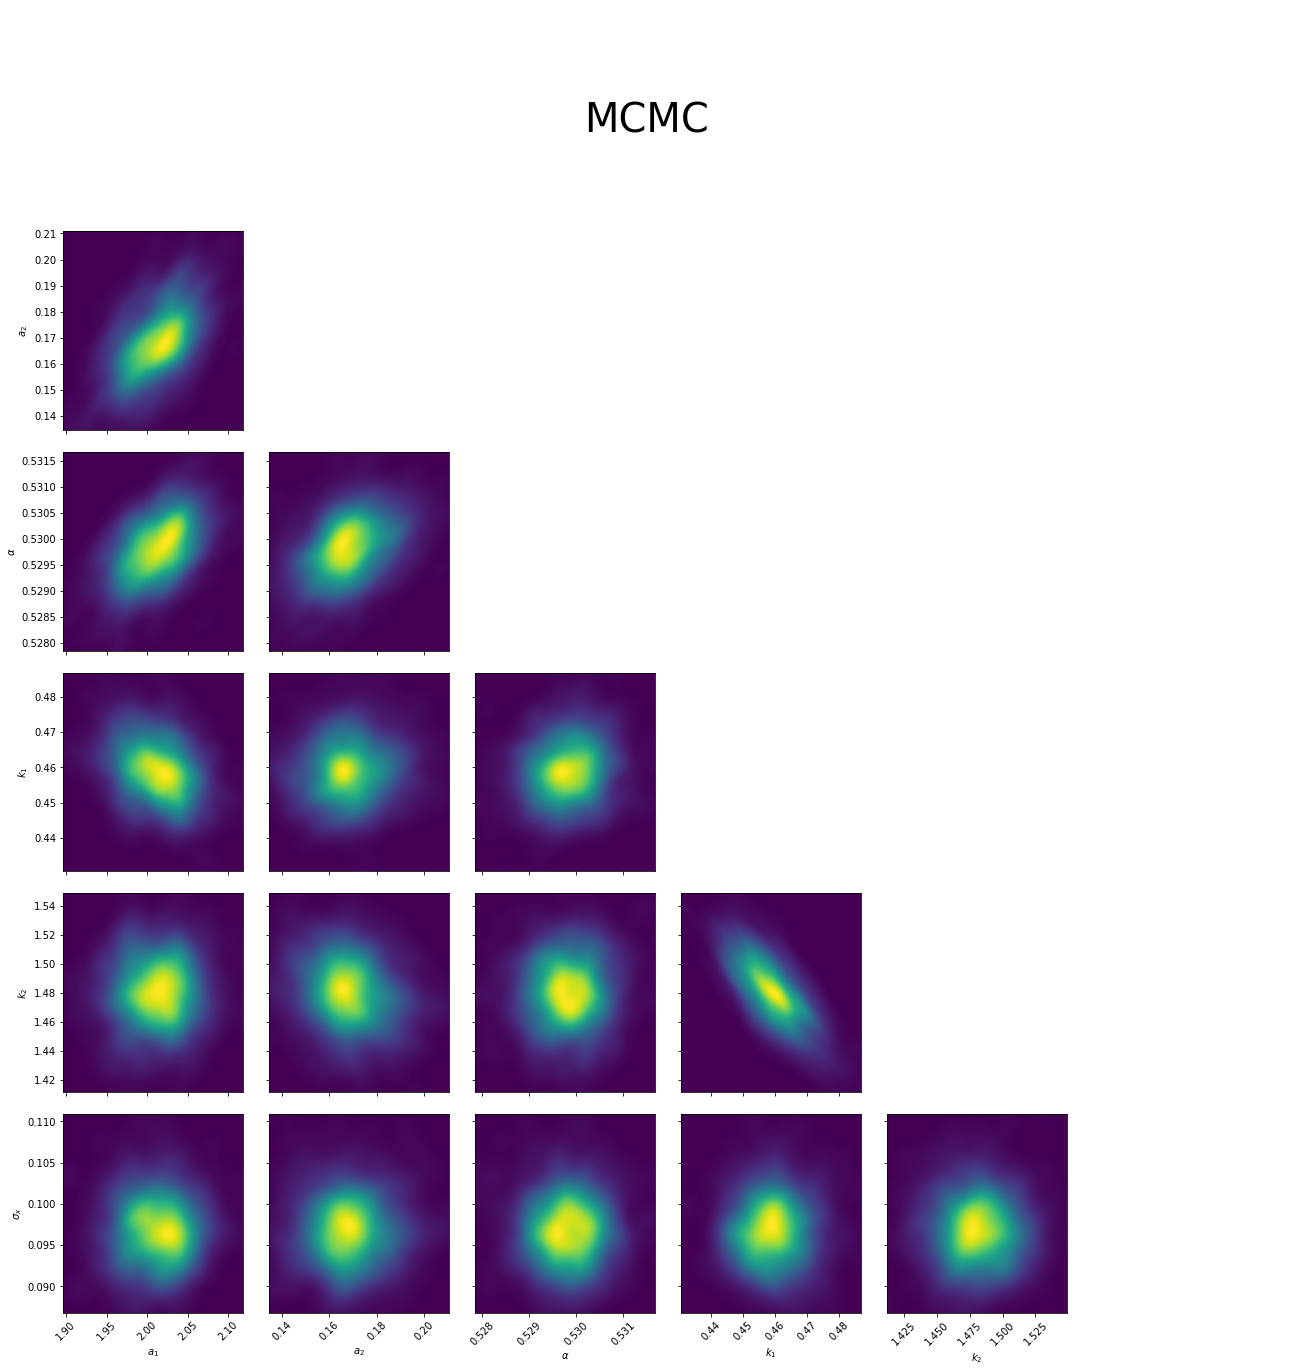

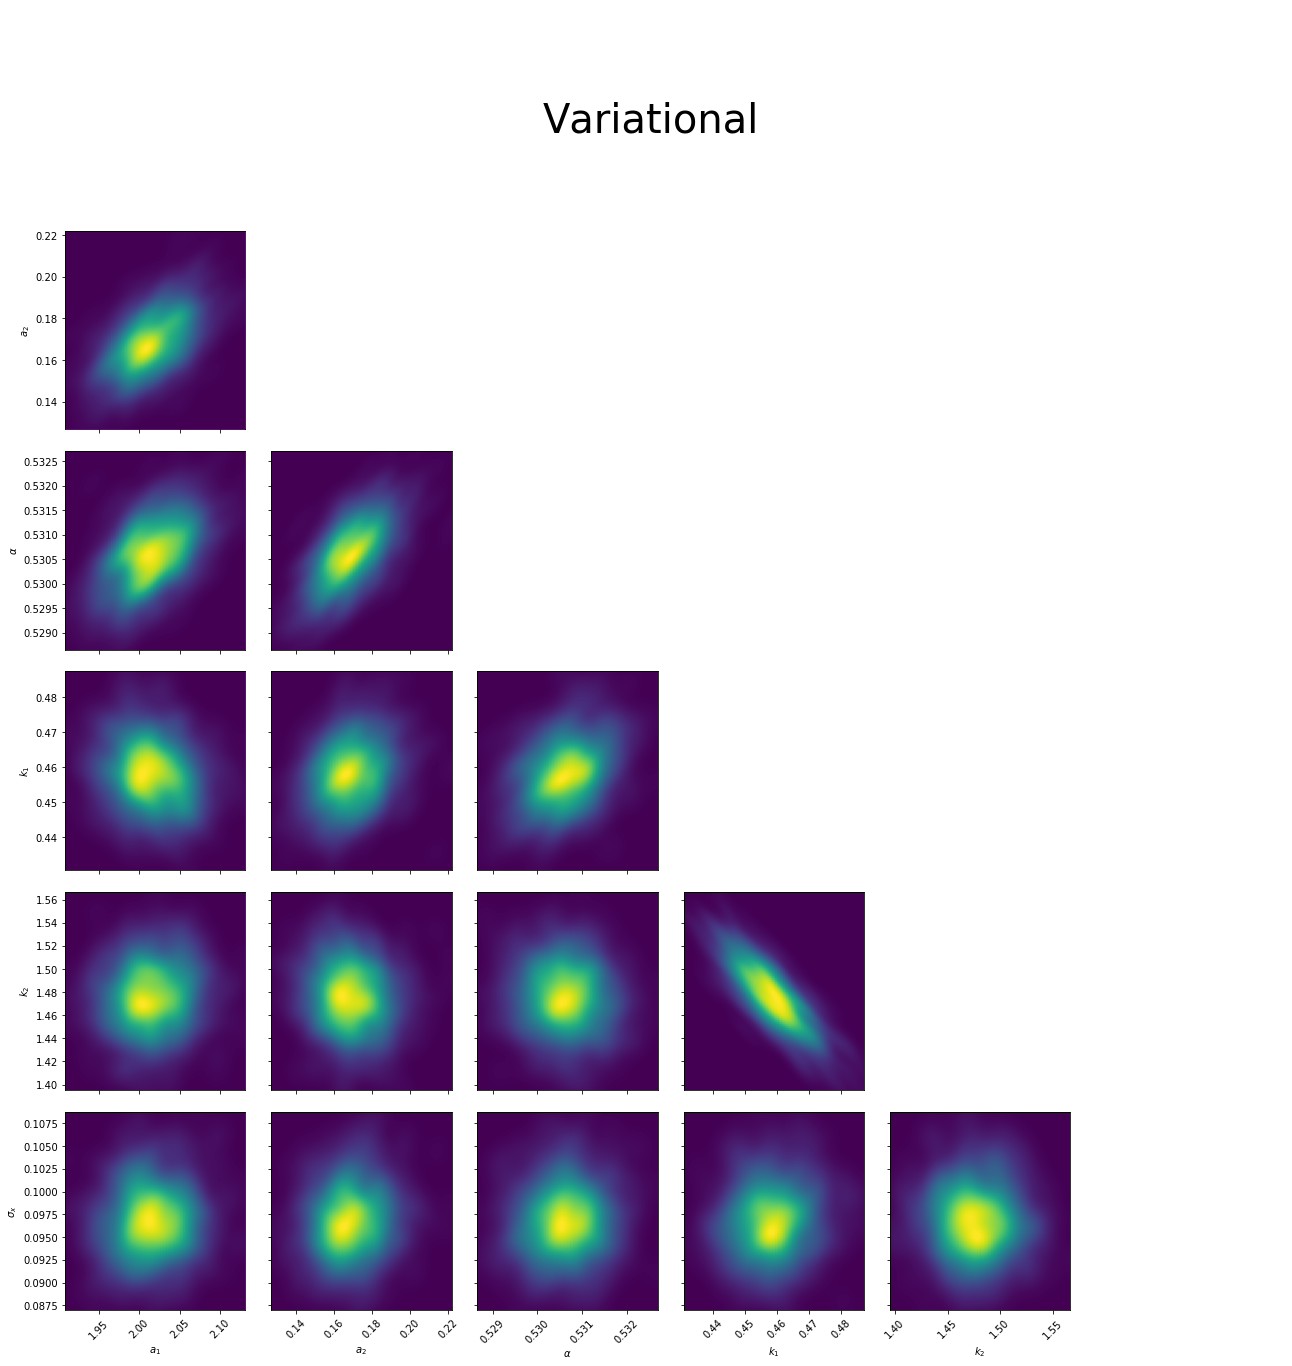

In [14]:
param_names = [r"$a_1$", r"$a_2$", r"$\alpha$", r"$k_1$", r"$k_2$", r"$\sigma_x$"]
pairwise(mc_params, 'MCMC', param_names);
pairwise(vb_params, 'Variational', param_names);


### Compare the marginals

In [ ]:
import seaborn as sns
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(9,9),"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
           "xtick.labelsize":15, "ytick.labelsize":15},style="white")
real_params.append(0.1)
for i, p in enumerate(param_names):
        
        # Add histogram subplot
        plt.subplot(3, 2, i+1)
        plt.axvline(real_params[i], linewidth=2.5, color='black')
        if i==0:
            sns.kdeplot(vb_params[:, i], color='magenta', linewidth = 2.5, label='Variational')
            sns.kdeplot(mc_params[:, i], color='orange', linewidth = 2.5,label='MCMC')
        else:
            sns.kdeplot(vb_params[:, i], linewidth = 2.5, color='magenta')
            sns.kdeplot(mc_params[:, i], linewidth = 2.5, color='orange')  

        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()

# Bonus sections! Multiple samples for ELBO evaluation

`Pyro` provides a vectorised (batched accross ELBO MC samples $L$) ELBO evaluation. We can take advantage of this if we want to use $L >1$ MC samples.

# Vectorised ELBO evaluation

In this case we evaluate the ODE sensitivities in parallel and thus use the following wrapper function.

In [2]:
from joblib import Parallel, delayed
import multiprocessing
# We have hard-coded the: n_jobs=5, change this accordingly

def solution_and_sens_parallel(params):
    
    if params.ndim ==1:
        return gw_ode_model.solve_with_sensitivities(params)  
    else:
        for i in range(params.shape[0]):
            
            ans = Parallel(n_jobs=5)(delayed(
                gw_ode_model.solve_with_sensitivities)(params[i].reshape((5,))) 
                                     for i in range(5))    
        return ans     

## Vectorised Custom ODE op

Note the way it operates is that it returns the VJP, but retaining the batch dimension accross the MC samples.

In [40]:
class VectorisedODEop(Function):  
    @staticmethod
    def forward(ctx, params): 
        numpy_params = params.detach().numpy()
        V_flag = False
        if numpy_params.ndim ==1:
            
            states, Jac_p, T, k, d = solution_and_sens_parallel(numpy_params)
            ctx.T, ctx.k, ctx.d, ctx.V = T, k, d, V_flag
        else:
            V_flag = True
            ans = solution_and_sens_parallel(numpy_params)
            states = np.stack([ans[i][0] for i in range(5)], axis=0)
            Jac_p = np.stack([ans[i][1] for i in range(5)], axis=0)
            
            ctx.T, ctx.k, ctx.d, ctx.L, ctx.V = ans[0][2], ans[0][3], ans[0][4], numpy_params.shape[0], V_flag
        ctx.save_for_backward(torch.as_tensor(Jac_p, dtype=params.dtype))
        return torch.as_tensor(states, dtype=params.dtype)

    @staticmethod
    def backward(ctx, grad_output):
        T = ctx.T
        d = ctx.d
        k = ctx.k
        V_flag = ctx.V
        bJac = ctx.saved_tensors[0]
        if not(V_flag):
            
            numpy_Jac = bJac.detach().numpy().reshape((k*T,d))
            g = grad_output.detach().numpy().reshape(k*T)
            vjp = g.T.dot(numpy_Jac)
        else:
            L = ctx.L
            numpy_Jac = bJac.detach().numpy().reshape((L,k*T,d))
            g = grad_output.detach().numpy().reshape(L,k*T)
            vjp = np.array([g[i].T.dot(numpy_Jac[i]) for i in range(L)]).reshape((L,1,1,d))            
        return torch.from_numpy(vjp)

In [41]:
y_torch = torch.tensor(Y,dtype=torch.float)

In [42]:
class VectorisedGoodwinGenModel(PyroModule):
    def __init__(self):        
        super(VectorisedGoodwinGenModel, self).__init__()
        self.ode_params = PyroSample(dist.Gamma(
            torch.tensor([2.0,2.0,2.0,2.0,2.0]),1.0).to_event(1) )      
        
    def forward(self, data):         
        scale = pyro.sample("scale", dist.HalfNormal(1.0))
        states = VectorisedODEop.apply(self.ode_params)
        with pyro.plate("map", len(data)):

            pyro.sample("obs",
                        dist.Normal(states, scale).to_event(1),
                        obs=data)
            return states

In [43]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
model = VectorisedGoodwinGenModel()
guide = AutoMultivariateNormal(model)
optim = AdagradRMSProp({"eta": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=5,max_plate_nesting=2,vectorize_particles=False))

In [44]:
def train():
    loss_trace = []
    for j in range(5000):
        # calculate the loss and take a gradient step
        loss = svi.step(y_torch)
        loss_trace.append(loss)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
    return loss_trace

In [45]:
loss_graph = train()
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

[iteration 0001] loss: 422.8781
[iteration 0501] loss: -124.8732
[iteration 1001] loss: -270.0701
[iteration 1501] loss: -287.5932
[iteration 2001] loss: -291.6387
[iteration 2501] loss: -294.3880
[iteration 3001] loss: -295.8411
[iteration 3501] loss: -297.2948
[iteration 4001] loss: -297.5267
[iteration 4501] loss: -298.2269
AutoMultivariateNormal.loc Parameter containing:
tensor([-2.3243,  0.6977, -1.7868, -0.6349, -0.7806,  0.3919],
       requires_grad=True)
AutoMultivariateNormal.scale_tril tensor([[ 0.0367,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0011,  0.0173,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0035,  0.0441,  0.0668,  0.0000,  0.0000,  0.0000],
        [-0.0005, -0.0002,  0.0007,  0.0010,  0.0000,  0.0000],
        [ 0.0009, -0.0061,  0.0064,  0.0015,  0.0164,  0.0000],
        [ 0.0020,  0.0003, -0.0019,  0.0016, -0.0136,  0.0094]],
       grad_fn=<AddBackward0>)
